In [30]:
import os
import pickle 
import random
import zlib
from collections import deque
from collections import namedtuple
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
resume = True
CHECKPOINT_PATH = 'deep_q_breakout_path_8'
MB_SIZE = 32
ER_BUFFER_SIZE = 1000000
COMPRESS_ER = True
EXPLORE_STEPS = 1000000
EPSILON_START = 1.0
EPSILON_END = 0.01
STATE_FRAMES = 4
SAVE_EVERY_X_STEPS = 10000
UPDATE_Q_NET_FREQ = 1
UPDATE_TARGET_NET_EVERY_X_STEPS = 10000
DISCOUNT_FACTOR = 0.99

In [0]:
def initialize():
    """Initialize the session, the networks, and the environment"""
    # Create environment
    env = gym.envs.make("BreakoutDeterministic-v4")

    tf.reset_default_graph()

    session = tf.Session()

    # Tracks the total nubmer of training steps
    tf.Variable(0, name='global_step', trainable=False)

    # Create q- and target- networks
    q_network = build_network("q_network")
    t_network = build_network("target_network")

    # create the operations to copy the q-net weights to the t-net
    q_net_weights = [t for t in tf.trainable_variables() if t.name.startswith(q_network.scope)]
    q_net_weights = sorted(q_net_weights, key=lambda v: v.name)
    t_net_weights = [t for t in tf.trainable_variables() if t.name.startswith(t_network.scope)]
    t_net_weights = sorted(t_net_weights, key=lambda v: v.name)

    t_net_updates = \
        [n2_v.assign(n1_v) for n1_v, n2_v in zip(q_net_weights, t_net_weights)]

    # pre-processor of game frames
    frame_proc = frame_preprocessor()

    optimizer = tf.train.AdamOptimizer(0.00025)
    # optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)

    # training op
    train_op = optimizer.minimize(q_network.loss, global_step=tf.train.get_global_step())

    # restore checkpoint
    saver = tf.train.Saver()

    if not os.path.exists(CHECKPOINT_PATH):
        os.mkdir(CHECKPOINT_PATH)

    checkpoint = tf.train.get_checkpoint_state(CHECKPOINT_PATH)
    if resume and checkpoint:
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())

        print("\nRestoring checkpoint...")
        saver.restore(session, checkpoint.model_checkpoint_path)
    else:
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())

    return session, \
           q_network, \
           t_network, \
           t_net_updates, \
           frame_proc, \
           saver, \
           train_op, \
           env



In [0]:
def build_network(scope: str, input_size=84, num_actions=4):
    """Builds the network graph."""

    with tf.variable_scope(scope):
        # Our input are STATE_FRAMES greyscale frames of shape 84, 84 each
        input_placeholder = tf.placeholder(dtype=np.float32,
                                           shape=[None, input_size, input_size, STATE_FRAMES])

        normalized_input = tf.to_float(input_placeholder) / 255.0

        # action prediction
        action_placeholder = tf.placeholder(dtype=tf.int32, shape=[None])

        # target action
        target_placeholder = tf.placeholder(dtype=np.float32, shape=[None])

        # Convolutional layers
        conv_1 = tf.layers.conv2d(normalized_input, 32, 8, 4,
                                  activation=tf.nn.relu)
        conv_2 = tf.layers.conv2d(conv_1, 64, 4, 2,
                                  activation=tf.nn.relu)
        conv_3 = tf.layers.conv2d(conv_2, 64, 3, 1,
                                  activation=tf.nn.relu)

        # Fully connected layers
        flattened = tf.layers.flatten(conv_3)
        fc_1 = tf.layers.dense(flattened, 512,
                               activation=tf.nn.relu)

        q_estimation = tf.layers.dense(fc_1, num_actions)

        # Get the predictions for the chosen actions only
        batch_size = tf.shape(normalized_input)[0]
        gather_indices = tf.range(batch_size) * tf.shape(q_estimation)[1] + action_placeholder
        action_predictions = tf.gather(tf.reshape(q_estimation, [-1]), gather_indices)

        # Calculate the loss
        # loss = tf.reduce_mean(tf.squared_difference(target_placeholder, action_predictions))
        loss = tf.losses.huber_loss(labels=target_placeholder, predictions=action_predictions, reduction=tf.losses.Reduction.MEAN)

    Network = namedtuple('Network',
                         'scope '
                         'input_placeholder '
                         'action_placeholder '
                         'target_placeholder '
                         'q_estimation '
                         'action_predictions '
                         'loss ')

    return Network(scope=scope,
                   input_placeholder=input_placeholder,
                   action_placeholder=action_placeholder,
                   target_placeholder=target_placeholder,
                   q_estimation=q_estimation,
                   action_predictions=action_predictions,
                   loss=loss)


In [0]:
def choose_next_action(state, net, epsilon):
    """Epsilon-greedy policy"""

    # choose an action given our last state
    tmp = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
    q_estimations = session.run(net.q_estimation,
        feed_dict={net.input_placeholder: np.reshape(state, (1,) + state.shape)})[0]

    tmp[np.argmax(q_estimations)] += (1.0 - epsilon)

    new_action = np.random.choice(np.arange(len(tmp)), p=tmp)

    return new_action

In [0]:
def frame_preprocessor():
    """Pre-processing the input data"""

    with tf.variable_scope("frame_processor"):
        input_placeholder = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
        processed_frame = tf.image.rgb_to_grayscale(input_placeholder)
        processed_frame = tf.image.crop_to_bounding_box(processed_frame, 34, 0, 160, 160)
        processed_frame = tf.image.resize_images(
            processed_frame,
            [84, 84],
            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        processed_frame = tf.squeeze(processed_frame)

    FramePreprocessor = namedtuple('FramePreprocessor', 'input_placeholder processed_frame')

    return FramePreprocessor(
        input_placeholder=input_placeholder,
        processed_frame=processed_frame)

In [0]:
def populate_experience_replay_buffer(buffer: deque, initial_buffer_size: int):
    """Initial population of the experience replay buffer"""

    # Initialize epsilon based on the current step
    epsilon_step = (EPSILON_START - EPSILON_END) / EXPLORE_STEPS
    epsilon = max(EPSILON_END,
                  EPSILON_START -
                  session.run(tf.train.get_global_step()) * epsilon_step)

    # Populate the replay memory with initial experience
    state = env.reset()
    state = session.run(frame_proc.processed_frame,
                        feed_dict={frame_proc.input_placeholder: state})

    state = np.stack([state] * STATE_FRAMES, axis=2)

    for i in range(initial_buffer_size):

        # Sample next state with the q_network
        action = choose_next_action(state, q_network, epsilon)

        # Perform one action step
        next_state, reward, terminal, info = env.step(action)
        next_state = session.run(frame_proc.processed_frame,
                                 feed_dict={frame_proc.input_placeholder: next_state})

        # Stack the game frames in a single array
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis=2)

        # Store the experience in ER
        if COMPRESS_ER:
            buffer.append(
                zlib.compress(
                    pickle.dumps((state, action, reward, next_state, terminal), 2), 2))
        else:
            buffer.append((state, action, reward, next_state, terminal))

        # Set next state as current
        if terminal:
            state = env.reset()
            state = session.run(frame_proc.processed_frame,
                                feed_dict={frame_proc.input_placeholder: state})

            state = np.stack([state] * STATE_FRAMES, axis=2)
        else:
            state = next_state

        print("\rExperience replay buffer: {} / {} initial ({} total)".format(
            len(buffer), initial_buffer_size, buffer.maxlen), end="")


In [0]:
def plot_stats(stats):
    """Plot the stats"""
    plt.figure()

    plt.xlabel("Episode")

    # plot the rewards
    # rolling mean of 50
    cumsum = np.cumsum(np.insert(stats.rewards, 0, 0))
    rewards = (cumsum[50:] - cumsum[:-50]) / float(50)

    fig, ax1 = plt.subplots()

    color = 'tab:red'

    ax1.set_ylabel('Reward', color=color)
    ax1.plot(rewards, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the episode lengths
    # rolling mean of 50
    cumsum = np.cumsum(np.insert(stats.lengths, 0, 0))
    lengths = (cumsum[50:] - cumsum[:-50]) / float(50)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Length', color=color)
    ax2.plot(lengths, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Populating replay memory...
Experience replay buffer: 100000 / 100000 initial (1000000 total)
Copied model parameters to target network.
Episode 1: time   173; reward 1.0; epsilon: 0.9998; loss: 0.015255; @ global step 173 with total reward 1.0
Episode 2: time   148; reward 0.0; epsilon: 0.9997; loss: 0.000024; @ global step 321 with total reward 1.0
Episode 3: time   132; reward 0.0; epsilon: 0.9996; loss: 0.001596; @ global step 453 with total reward 1.0
Episode 4: time   136; reward 0.0; epsilon: 0.9994; loss: 0.000969; @ global step 589 with total reward 1.0
Episode 5: time   137; reward 0.0; epsilon: 0.9993; loss: 0.000262; @ global step 726 with total reward 1.0
Episode 6: time   169; reward 1.0; epsilon: 0.9991; loss: 0.000055; @ global step 895 with total reward 2.0
Episode 7: time   231; reward 2.0; epsilon: 0.9989; loss: 0.016223; @ global step 1126 with tot

KeyboardInterrupt: ignored

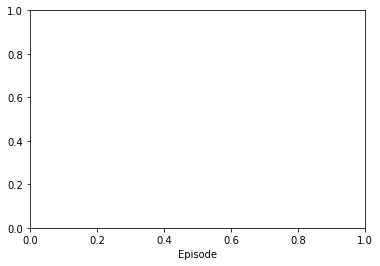

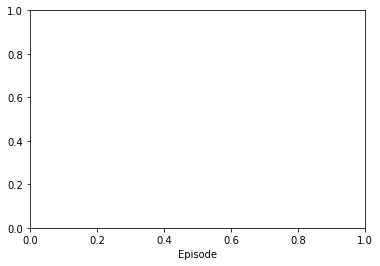

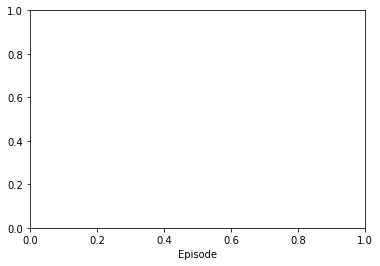

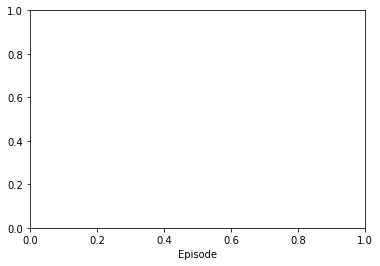

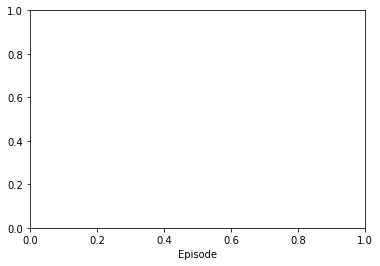

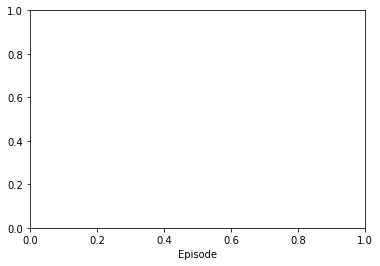

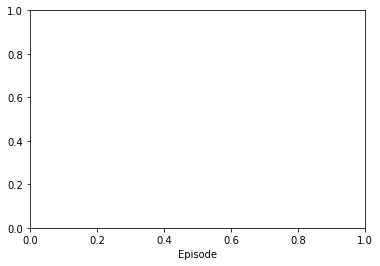

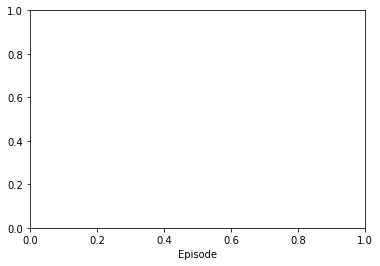

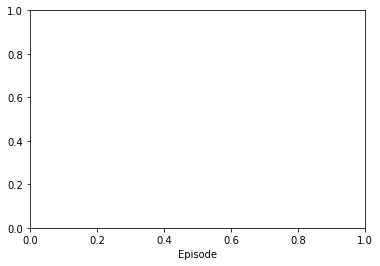

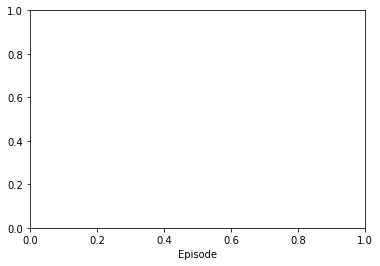

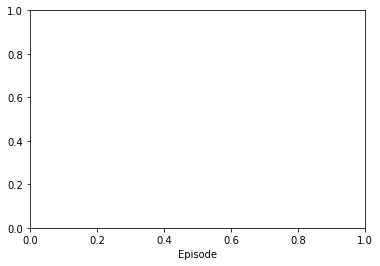

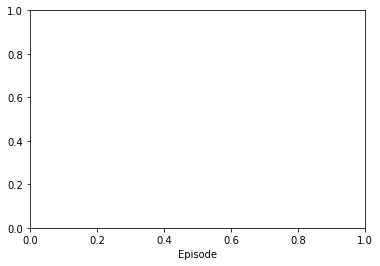

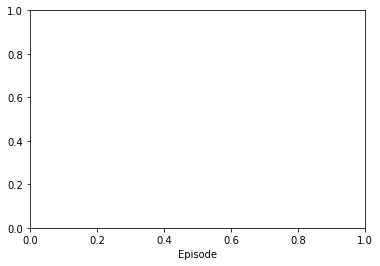

In [40]:
def deep_q_learning():
    """The Q-learning training process"""

    # build experience replay
    observations = deque(maxlen=ER_BUFFER_SIZE)

    print("Populating replay memory...")
    populate_experience_replay_buffer(observations, 100000)

    # initialize statistics
    stats = namedtuple('Stats', 'rewards lengths')(rewards=list(), lengths=list())
    global_time = session.run(tf.train.get_global_step())
    time = 0

    episode = 1

    episode_reward = 0
    global_reward = 0

    # Start the training with an initial state
    state = env.reset()
    state = session.run(frame_proc.processed_frame,
                        feed_dict={frame_proc.input_placeholder: state})
    state = np.stack([state] * STATE_FRAMES, axis=2)

    while True:
        # env.render()

        # Initialize epsilon based on the current step
        epsilon_step = (EPSILON_START - EPSILON_END) / EXPLORE_STEPS
        epsilon = max(EPSILON_END, EPSILON_START - (global_time - 1) * epsilon_step)

        # Copy q-net weights to the target-net
        if global_time % UPDATE_TARGET_NET_EVERY_X_STEPS == 0:
            session.run(t_net_updates)
            print("\nCopied model parameters to target network.")

        # Sample next action
        action = choose_next_action(state, q_network, epsilon)

        # Perform one step with the selected action
        next_state, reward, terminal, info = env.step(action)

        # This is how we pre-process
        next_state = session.run(frame_proc.processed_frame,
                                 feed_dict={frame_proc.input_placeholder: next_state})

        # Stack the game frames in a single array
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis=2)

        # Store the experience in ER
        if COMPRESS_ER:
            observations.append(
                zlib.compress(pickle.dumps((state, action, reward, next_state, terminal), 2), 2))
        else:
            observations.append((state, action, reward, next_state, terminal))

        # Sample a mini-batch from the experience replay memory
        mini_batch = random.sample(observations, MB_SIZE)
        if COMPRESS_ER:
            mini_batch = [pickle.loads(zlib.decompress(comp_item)) for comp_item in mini_batch]

        states_batch, action_batch, reward_batch, next_states_batch, terminal_batch = \
            map(np.array, zip(*mini_batch))

        # Double Q-learning
        if global_time % UPDATE_Q_NET_FREQ == 0:
            # First predict the next q values with the q-network
            q_values_next = session.run(q_network.q_estimation,
                                        feed_dict={q_network.input_placeholder: next_states_batch})

            # The best action according to the q-network
            best_actions = np.argmax(q_values_next, axis=1)

            # Next, predict the next q values with the target-network
            q_values_next_target = session.run(t_network.q_estimation,
                                               feed_dict={t_network.input_placeholder: next_states_batch})

            # Calculate q values and targets
            # Use the t-network estimations
            # But with the best action, selected by the q-network (Double Q-learning)
            targets_batch = reward_batch + \
                            np.invert(terminal_batch).astype(np.float32) * \
                            DISCOUNT_FACTOR * \
                            q_values_next_target[np.arange(MB_SIZE), best_actions]

            _, loss = session.run([train_op, q_network.loss],
                                  feed_dict={
                                      q_network.input_placeholder: states_batch,
                                      q_network.action_placeholder: action_batch,
                                      q_network.target_placeholder: targets_batch})

        episode_reward += reward
        global_reward += reward
        time += 1
        global_time += 1

        print("\rEpisode {}: "
              "time {:5}; "
              "reward {}; "
              "epsilon: {:.4f}; "
              "loss: {:.6f}; "
              "@ global step {} "
              "with total reward {}".format(
            episode,
            time,
            episode_reward,
            epsilon,
            loss,
            global_time,
            global_reward), end="")

        if terminal:
            # Episode end

            print()

            stats.rewards.append(int(episode_reward))
            stats.lengths.append(time)

            time = 0
            episode_reward = 0
            episode += 1

            state = env.reset()
            state = session.run(frame_proc.processed_frame,
                                feed_dict={frame_proc.input_placeholder: state})
            state = np.stack([state] * STATE_FRAMES, axis=2)
        else:
            # Set next state as current
            state = next_state

        # save checkpoints for later
        if global_time % SAVE_EVERY_X_STEPS == 0:
            saver.save(session, CHECKPOINT_PATH + '/network',
                       global_step=tf.train.get_global_step())

            # plot the results and save the figure
            plot_stats(stats)

            fig_file = CHECKPOINT_PATH + '/stats.png'
            if os.path.isfile(fig_file):
                os.remove(fig_file)

            plt.savefig(fig_file)
            plt.close()

            # save the stats
            with open(CHECKPOINT_PATH + '/stats.arr', 'wb') as f:
                pickle.dump((stats.rewards, stats.lengths), f)


if __name__ == '__main__':
    session, q_network, t_network, t_net_updates, frame_proc, saver, train_op, env = \
        initialize()
    deep_q_learning()